<a href="https://colab.research.google.com/github/AnetDavis/heart-disease-risk-prediction-/blob/main/Copy_of_PARKINSON_LAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install torch torchvision scikit-learn matplotlib seaborn optuna

import zipfile
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)

# Optuna for Bayesian optimization
import optuna
from optuna.trial import TrialState

# Extract dataset
dataset_path = "/content/archive (2).zip"
extract_to = "/content/Contents"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to {extract_to}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.4 MB/s eta 0:00:00
Dataset extracted to /content/Contents


In [ ]:
def collect_image_paths(directory):
    """Collect all image file paths recursively"""
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Dataset paths and configuration
dataset_path = '/content/Contents/parkinsons_dataset'
output_path = '/content/split_dataset'
class_dirs = ['normal', 'parkinson']
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

# Create output directory
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Split and copy files
for class_dir in class_dirs:
    class_path = os.path.join(dataset_path, class_dir)
    image_paths = collect_image_paths(class_path)
    if len(image_paths) == 0:
        print(f"No images found in {class_path}. Skipping...")
        continue

    # Split dataset
    train_files, temp_files = train_test_split(image_paths, test_size=(val_ratio + test_ratio), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Copy files to respective directories
    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_dir = os.path.join(output_path, split, class_dir)
        os.makedirs(split_dir, exist_ok=True)
        for file_path in split_files:
            shutil.copy(file_path, split_dir)

print("Dataset split completed successfully!")

# Verify dataset sizes
def count_files(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

train_dir = '/content/split_dataset/train'
val_dir = '/content/split_dataset/val'
test_dir = '/content/split_dataset/test'

print(f"Train files: {count_files(train_dir)}")
print(f"Validation files: {count_files(val_dir)}")
print(f"Test files: {count_files(test_dir)}")

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Dataset split completed successfully!
Train files: 581
Validation files: 124
Test files: 126
Using device: cpu


In [ ]:
# Enhanced data augmentation to prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simple transformations for validation/test (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Get class names
class_names = train_dataset.classes
print(f"Class names: {class_names}")

# Create DataLoaders with appropriate batch sizes
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(class_names)),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

Class names: ['normal', 'parkinson']
Class weights: tensor([0.6803, 1.8864])


In [ ]:
# REPLACE the old create_model function with this enhanced version
def create_model(model_name='ResNet-18', hidden_units=256, dropout_rate=0.7):
    """Create and configure different model architectures"""
    if model_name == 'ResNet-18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        # Freeze early layers to prevent overfitting
        for param in model.parameters():
            param.requires_grad = False
        # Modify final layers with regularization
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, len(class_names))
        )

    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(num_ftrs, hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, len(class_names))
        )

    elif model_name == 'Simple-CNN':
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes, hidden_units=256, dropout_rate=0.7):
                super(SimpleCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten()
                )
                self.classifier = nn.Sequential(
                    nn.Linear(128, hidden_units),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x

        model = SimpleCNN(len(class_names), hidden_units, dropout_rate)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model.to(device)

# NEW: Function to get all available models
def get_model_dict():
    """Returns a dictionary of model names and their constructors"""
    return {
        'ResNet-18': lambda hu, dr: create_model('ResNet-18', hu, dr),
        'EfficientNet-B0': lambda hu, dr: create_model('EfficientNet-B0', hu, dr),
        'Simple-CNN': lambda hu, dr: create_model('Simple-CNN', hu, dr)
    }

In [ ]:
# REPLACE the old optimization functions with Bayesian optimization

def objective(trial):
    """Objective function for Optuna to maximize (validation accuracy)"""

    # Add validation to prevent overfitting during optimization
    if trial.number > 5:  # After first few trials
        # Check if previous trials are showing signs of overfitting
        completed_trials = [t for t in trial.study.trials if t.state == TrialState.COMPLETE]
        if len(completed_trials) > 5:
            recent_accuracies = [t.value for t in completed_trials[-5:]]
            if all(acc > 0.95 for acc in recent_accuracies):
                # Too good too fast - likely overfitting
                return 0.0  # Penalize this trial

    # 1. Suggest values for hyperparameters
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    hidden_units = trial.suggest_categorical('hidden_units', [64, 128])  # Removed 256 to reduce complexity
    dropout_rate = trial.suggest_float('dropout_rate', 0.5, 0.8)  # Increased range from 0.3-0.7 to 0.5-0.8
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)  # Increased from 1e-6-1e-3 to 1e-5-1e-2

    # 2. Create model with suggested hyperparameters
    model = create_model('ResNet-18', hidden_units, dropout_rate)

    # 3. Define loss and optimizer with label smoothing
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)  # Added label smoothing
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 4. Short training and validation loop
    num_epochs = 5
    best_val_accuracy = 0.0
    patience_counter = 0
    patience = 2  # Add early stopping within optimization

    for epoch in range(num_epochs):
        # Training
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total

        # Early stopping check within optimization
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break  # Stop early if not improving

    return best_val_accuracy

# Perform Bayesian hyperparameter optimization
print("Performing Bayesian Hyperparameter Optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Increased from 15 to 25 trials

# Get the best parameters
best_params = study.best_params
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial (Validation Accuracy: {study.best_value:.4f}):")
print(f"Best hyperparameters: {best_params}")

[I 2025-09-17 13:33:06,334] A new study created in memory with name: no-name-b145f8c8-0764-4172-8ab3-d043ded5cabc


Performing Bayesian Hyperparameter Optimization with Optuna...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]
[I 2025-09-17 13:37:05,577] Trial 0 finished with value: 0.9354838709677419 and parameters: {'learning_rate': 0.00079777522677946, 'hidden_units': 128, 'dropout_rate': 0.5793791902280082, 'weight_decay': 0.002623669031134141}. Best is trial 0 with value: 0.9354838709677419.
[I 2025-09-17 13:40:18,805] Trial 1 finished with value: 0.782258064516129 and parameters: {'learning_rate': 0.00013284249024485552, 'hidden_units': 128, 'dropout_rate': 0.7674224148761608, 'weight_decay': 0.0009863225362049077}. Best is trial 0 with value: 0.9354838709677419.
[I 2025-09-17 13:44:23,168] Trial 2 finished with value: 0.9596774193548387 and parameters: {'learning_rate': 0.0009868863942682177, 'hidden_units': 64, 'dropout_rate': 0.7243714445700946, 'weight_decay': 0.00013802410709496228}. Best is trial 2 with value: 0.9596774193548387.
[I 2025-09-17 13:48:24,952] Trial 3 finished with value: 0.8467741935483871 and parameters: {'learning_rate': 0.00010

Number of finished trials: 25
Best trial (Validation Accuracy: 0.9758):
Best hyperparameters: {'learning_rate': 0.0009125100307807701, 'hidden_units': 128, 'dropout_rate': 0.677745918188219, 'weight_decay': 0.009738878838928527}


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    """Training function with comprehensive monitoring and MixUp augmentation"""
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 7  # Increased from 5 to 7

    # MixUp parameters
    mixup_alpha = 0.2

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp augmentation
            if mixup_alpha > 0:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            else:
                targets_a, targets_b = labels, labels
                lam = 1.0

            optimizer.zero_grad()
            outputs = model(inputs)

            # Use MixUp criterion if enabled
            if mixup_alpha > 0:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # For accuracy calculation, use original labels
            _, predicted = torch.max(outputs, 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())  # Use original labels for accuracy

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)

        # Validation phase (no MixUp)
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}, Patience: {patience_counter}/{patience}")
        print("-" * 60)

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

def validate_model(model, val_loader, criterion):
    """Validation function"""
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    return val_loss, val_accuracy


MULTI-MODEL COMPARISON

Training and Evaluating: ResNet-18
Epoch 1/15
Train - Loss: 0.7616, Acc: 0.5353
Val - Loss: 0.5607, Acc: 0.7339
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 2/15
Train - Loss: 0.5258, Acc: 0.6558
Val - Loss: 0.5288, Acc: 0.7258
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 3/15
Train - Loss: 0.5353, Acc: 0.6540
Val - Loss: 0.4891, Acc: 0.8145
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 4/15
Train - Loss: 0.5003, Acc: 0.6936
Val - Loss: 0.4452, Acc: 0.9194
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 5/15
Train - Loss: 0.5078, Acc: 0.6713
Val - Loss: 0.4278, Acc: 0.9194
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 6/15
Train - Loss: 0.4822, Acc: 0.6833
Val - Loss: 0.4487, Acc: 0.8306
LR: 0.000913, Patience: 1/7
-----

100%|██████████| 20.5M/20.5M [00:00<00:00, 165MB/s]


Epoch 1/15
Train - Loss: 0.7071, Acc: 0.5439
Val - Loss: 0.5796, Acc: 0.7661
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 2/15
Train - Loss: 0.5559, Acc: 0.6644
Val - Loss: 0.4903, Acc: 0.8387
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 3/15
Train - Loss: 0.5811, Acc: 0.6506
Val - Loss: 0.4812, Acc: 0.8468
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 4/15
Train - Loss: 0.4982, Acc: 0.7126
Val - Loss: 0.4892, Acc: 0.8871
LR: 0.000913, Patience: 1/7
------------------------------------------------------------
Epoch 5/15
Train - Loss: 0.5321, Acc: 0.6351
Val - Loss: 0.4535, Acc: 0.9194
LR: 0.000913, Patience: 0/7
------------------------------------------------------------
Epoch 6/15
Train - Loss: 0.5094, Acc: 0.6833
Val - Loss: 0.4640, Acc: 0.9274
LR: 0.000913, Patience: 1/7
------------------------------------------------------------
Epoc

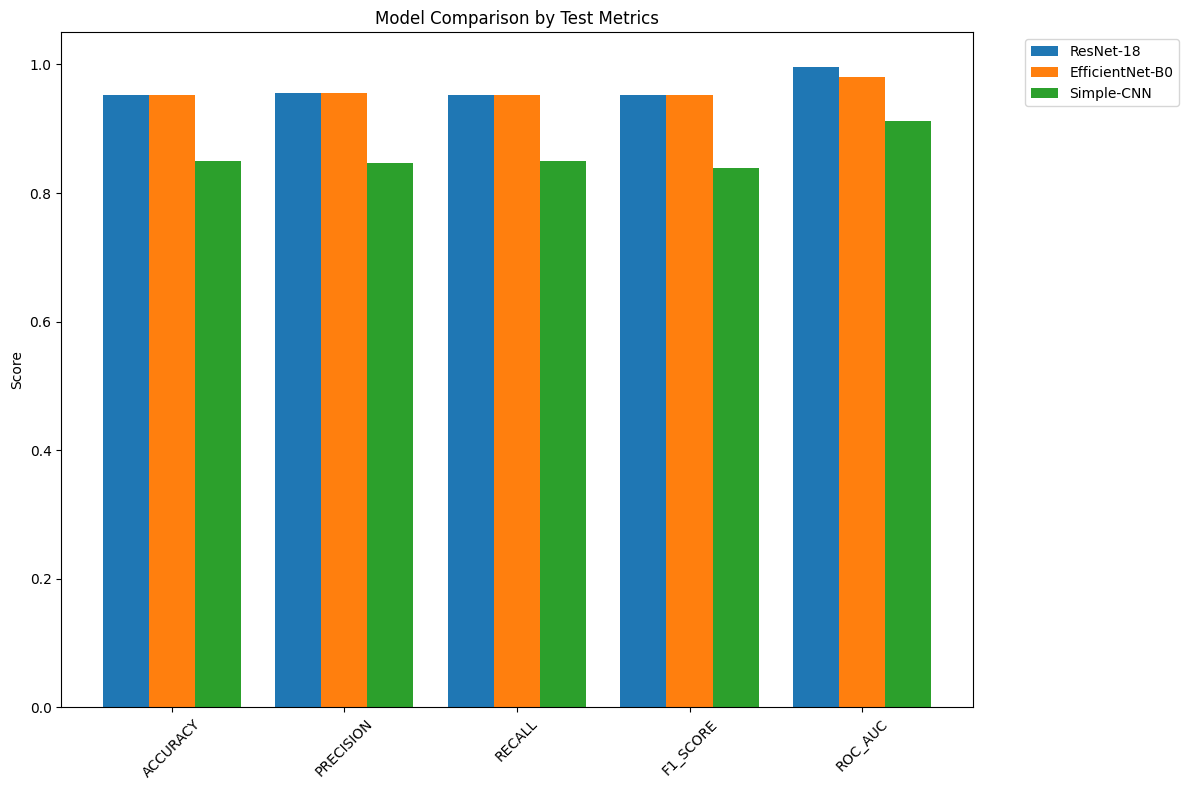

In [ ]:
# ==================== MODEL DEFINITIONS ====================
def create_model(model_name='ResNet-18', hidden_units=128, dropout_rate=0.7):  # Reduced hidden_units, increased dropout
    """Create and configure different model architectures"""
    if model_name == 'ResNet-18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        # Freeze early layers to prevent overfitting
        for param in model.parameters():
            param.requires_grad = False
        # Modify final layers with regularization
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, len(class_names))
        )

    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(num_ftrs, hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, len(class_names))
        )

    elif model_name == 'Simple-CNN':
        class SimpleCNN(nn.Module):
            def __init__(self, num_classes, hidden_units=128, dropout_rate=0.7):  # Reduced hidden_units, increased dropout
                super(SimpleCNN, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten()
                )
                self.classifier = nn.Sequential(
                    nn.Linear(128, hidden_units),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = self.classifier(x)
                return x

        model = SimpleCNN(len(class_names), hidden_units, dropout_rate)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model.to(device)

def get_model_dict():
    """Returns a dictionary of model names and their constructors with proper parameter handling"""
    def create_resnet18_wrapper(hidden_units=128, dropout_rate=0.7):  # Reduced hidden_units, increased dropout
        return create_model('ResNet-18', hidden_units, dropout_rate)

    def create_efficientnet_wrapper(hidden_units=128, dropout_rate=0.7):  # Reduced hidden_units, increased dropout
        return create_model('EfficientNet-B0', hidden_units, dropout_rate)

    def create_simple_cnn_wrapper(hidden_units=128, dropout_rate=0.7):  # Reduced hidden_units, increased dropout
        return create_model('Simple-CNN', hidden_units, dropout_rate)

    return {
        'ResNet-18': create_resnet18_wrapper,
        'EfficientNet-B0': create_efficientnet_wrapper,
        'Simple-CNN': create_simple_cnn_wrapper
    }

# ==================== TRAINING FUNCTIONS ====================
# Add MixUp functions before train_model
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and mixing coefficient"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """MixUp loss calculation"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=7):  # Increased patience
    """Training function with comprehensive monitoring and overfitting prevention"""
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    # MixUp parameter
    mixup_alpha = 0.2

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply MixUp augmentation
            if mixup_alpha > 0:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            else:
                targets_a, targets_b = labels, labels
                lam = 1.0

            optimizer.zero_grad()
            outputs = model(inputs)

            # Use MixUp criterion if enabled
            if mixup_alpha > 0:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # For accuracy calculation, use original labels
            _, predicted = torch.max(outputs, 1)
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())  # Use original labels for accuracy

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)

        # Validation phase (no MixUp)
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}")
        print(f"Val - Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}, Patience: {patience_counter}/{patience}")
        print("-" * 60)

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

def validate_model(model, val_loader, criterion):
    """Validation function"""
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    return val_loss, val_accuracy

# ==================== EVALUATION FUNCTIONS ====================
def comprehensive_evaluation(model, dataloader, class_names):
    """Comprehensive model evaluation with medical metrics"""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1_score': f1_score(all_labels, all_preds, average='weighted'),
        'roc_auc': roc_auc_score(all_labels, np.array(all_probs)[:, 1]) if len(class_names) == 2 else None
    }

    # Confusion matrix and class-wise metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_metrics = calculate_class_metrics(cm, class_names)

    return metrics, cm, class_metrics, all_probs

def calculate_class_metrics(cm, class_names):
    """Calculate medical metrics for each class"""
    class_metrics = {}
    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        class_metrics[class_name] = {
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'npv': tn / (tn + fn) if (tn + fn) > 0 else 0
        }
    return class_metrics

# ==================== MULTI-MODEL COMPARISON ====================
print("\n" + "="*60)
print("MULTI-MODEL COMPARISON")
print("="*60)

model_dict = get_model_dict()
all_results = {}

# Use best parameters from optimization with reduced complexity
common_params = {
    'hidden_units': 128,  # Reduced from 256 to 128
    'dropout_rate': best_params.get('dropout_rate', 0.7)  # Increased from 0.5833 to 0.7
}

for model_name, model_constructor in model_dict.items():
    print(f"\n{'='*50}")
    print(f"Training and Evaluating: {model_name}")
    print(f"{'='*50}")

    # Create model with proper parameter passing
    model = model_constructor(
        hidden_units=common_params['hidden_units'],
        dropout_rate=common_params['dropout_rate']
    )

    # Define loss, optimizer with increased weight decay and label smoothing
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)  # Added label smoothing
    optimizer = optim.Adam(model.parameters(),
                          lr=best_params.get('learning_rate', 0.000634),
                          weight_decay=1e-4)  # Increased from 1.593e-06 to 1e-4

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, min_lr=1e-7)

    # Train the model with more patience
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        epochs=15, patience=7  # Increased from 5 to 7
    )

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model.pth'))
    test_metrics, test_cm, test_class_metrics, test_probs = comprehensive_evaluation(model, test_loader, class_names)

    # Store the results
    all_results[model_name] = {
        'test_metrics': test_metrics,
        'test_cm': test_cm,
        'test_class_metrics': test_class_metrics,
        'train_history': (train_losses, val_losses, train_accuracies, val_accuracies),
        'test_probs': test_probs
    }

    print(f"Completed {model_name}. Test Accuracy: {test_metrics['accuracy']:.4f}")

# Compare model performance
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = []
metrics_to_show = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for model_name, results in all_results.items():
    row = [model_name]
    for metric in metrics_to_show:
        row.append(f"{results['test_metrics'][metric]:.4f}")
    comparison_data.append(row)

# Create comparison table
import pandas as pd
df_comparison = pd.DataFrame(comparison_data,
                            columns=['Model'] + [m.upper() for m in metrics_to_show])
print(df_comparison.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(metrics_to_show))
width = 0.8 / len(all_results)

for i, (model_name, results) in enumerate(all_results.items()):
    values = [results['test_metrics'][m] for m in metrics_to_show]
    rects = ax.bar(x + i*width - (width*(len(all_results)-1)/2), values, width, label=model_name)

ax.set_ylabel('Score')
ax.set_title('Model Comparison by Test Metrics')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_to_show])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ==================== PLOTTING FUNCTIONS ====================
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, test_metrics, test_cm, class_names, test_class_metrics):
    """Plot comprehensive results"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Training history - Loss
    ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', marker='s', linewidth=2)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add final epoch annotation
    ax1.annotate(f'Final: {val_losses[-1]:.3f}',
                xy=(len(val_losses)-1, val_losses[-1]),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Training history - Accuracy
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', marker='s', linewidth=2)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add final epoch annotation
    ax2.annotate(f'Final: {val_accuracies[-1]:.3f}',
                xy=(len(val_accuracies)-1, val_accuracies[-1]),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    # Confusion matrix with percentages
    cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    # Add percentage annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if test_cm[i, j] > 0:  # Only add text for non-zero cells
                ax3.text(j+0.5, i+0.3, f'{cm_percent[i, j]:.1f}%',
                        ha='center', va='center', fontsize=9, color='red')

    ax3.set_title('Confusion Matrix', fontsize=14)
    ax3.set_ylabel('True Label', fontsize=12)
    ax3.set_xlabel('Predicted Label', fontsize=12)

    # Metrics comparison
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metrics_values = [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1_score'],
        test_metrics['roc_auc'] if test_metrics['roc_auc'] is not None else 0
    ]

    colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bars = ax4.bar(metrics_names, metrics_values, color=colors, alpha=0.8)
    ax4.set_title('Test Set Performance Metrics', fontsize=14)
    ax4.set_ylabel('Score', fontsize=12)
    ax4.set_ylim(0, 1.1)
    ax4.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

def plot_class_performance(test_class_metrics, class_names):
    """Plot class-wise performance metrics"""
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Sensitivity and Specificity
    metrics = ['sensitivity', 'specificity']
    colors = ['#ff7f0e', '#1f77b4']

    for i, metric in enumerate(metrics):
        values = [test_class_metrics[cls][metric] for cls in class_names]
        ax[0].bar(np.arange(len(class_names)) + i*0.3, values, 0.3,
                 label=metric.capitalize(), color=colors[i], alpha=0.8)

        # Add value labels on bars
        for j, value in enumerate(values):
            ax[0].text(j + i*0.3, value + 0.02, f'{value:.3f}',
                      ha='center', va='bottom', fontsize=10)

    ax[0].set_xlabel('Classes', fontsize=12)
    ax[0].set_ylabel('Score', fontsize=12)
    ax[0].set_title('Sensitivity and Specificity by Class', fontsize=14)
    ax[0].set_xticks(np.arange(len(class_names)) + 0.15)
    ax[0].set_xticklabels([name.capitalize() for name in class_names])
    ax[0].legend()
    ax[0].set_ylim(0, 1.1)
    ax[0].grid(True, alpha=0.3)

    # Precision and NPV
    metrics = ['precision', 'npv']
    colors = ['#2ca02c', '#d62728']

    for i, metric in enumerate(metrics):
        values = [test_class_metrics[cls][metric] for cls in class_names]
        ax[1].bar(np.arange(len(class_names)) + i*0.3, values, 0.3,
                 label=metric.upper(), color=colors[i], alpha=0.8)

        # Add value labels on bars
        for j, value in enumerate(values):
            ax[1].text(j + i*0.3, value + 0.02, f'{value:.3f}',
                      ha='center', va='bottom', fontsize=10)

    ax[1].set_xlabel('Classes', fontsize=12)
    ax[1].set_ylabel('Score', fontsize=12)
    ax[1].set_title('Precision and NPV by Class', fontsize=14)
    ax[1].set_xticks(np.arange(len(class_names)) + 0.15)
    ax[1].set_xticklabels([name.capitalize() for name in class_names])
    ax[1].legend()
    ax[1].set_ylim(0, 1.1)
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_roc_curve(all_labels, all_probs, class_names):
    """Plot ROC curve for binary classification"""
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)

        # Add AUC text box
        textstr = f'AUC = {roc_auc:.3f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        plt.text(0.6, 0.1, textstr, fontsize=12, verticalalignment='top', bbox=props)

        plt.show()
    else:
        print("ROC curve only available for binary classification")

def get_test_predictions(model, dataloader):
    """Get predictions and labels for test set"""
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_probs), np.array(all_preds)
# ==================== END PLOTTING FUNCTIONS ====================


Best performing model: ResNet-18

DETAILED ANALYSIS FOR BEST MODEL: ResNet-18
Accuracy: 0.9524
Precision: 0.9562
Recall: 0.9524
F1-Score: 0.9532
ROC-AUC: 0.9965

Class-wise Performance:
normal:
  Sensitivity: 0.9457
  Specificity: 0.9706
  Precision: 0.9886
  NPV: 0.8684
parkinson:
  Sensitivity: 0.9706
  Specificity: 0.9457
  Precision: 0.8684
  NPV: 0.9886


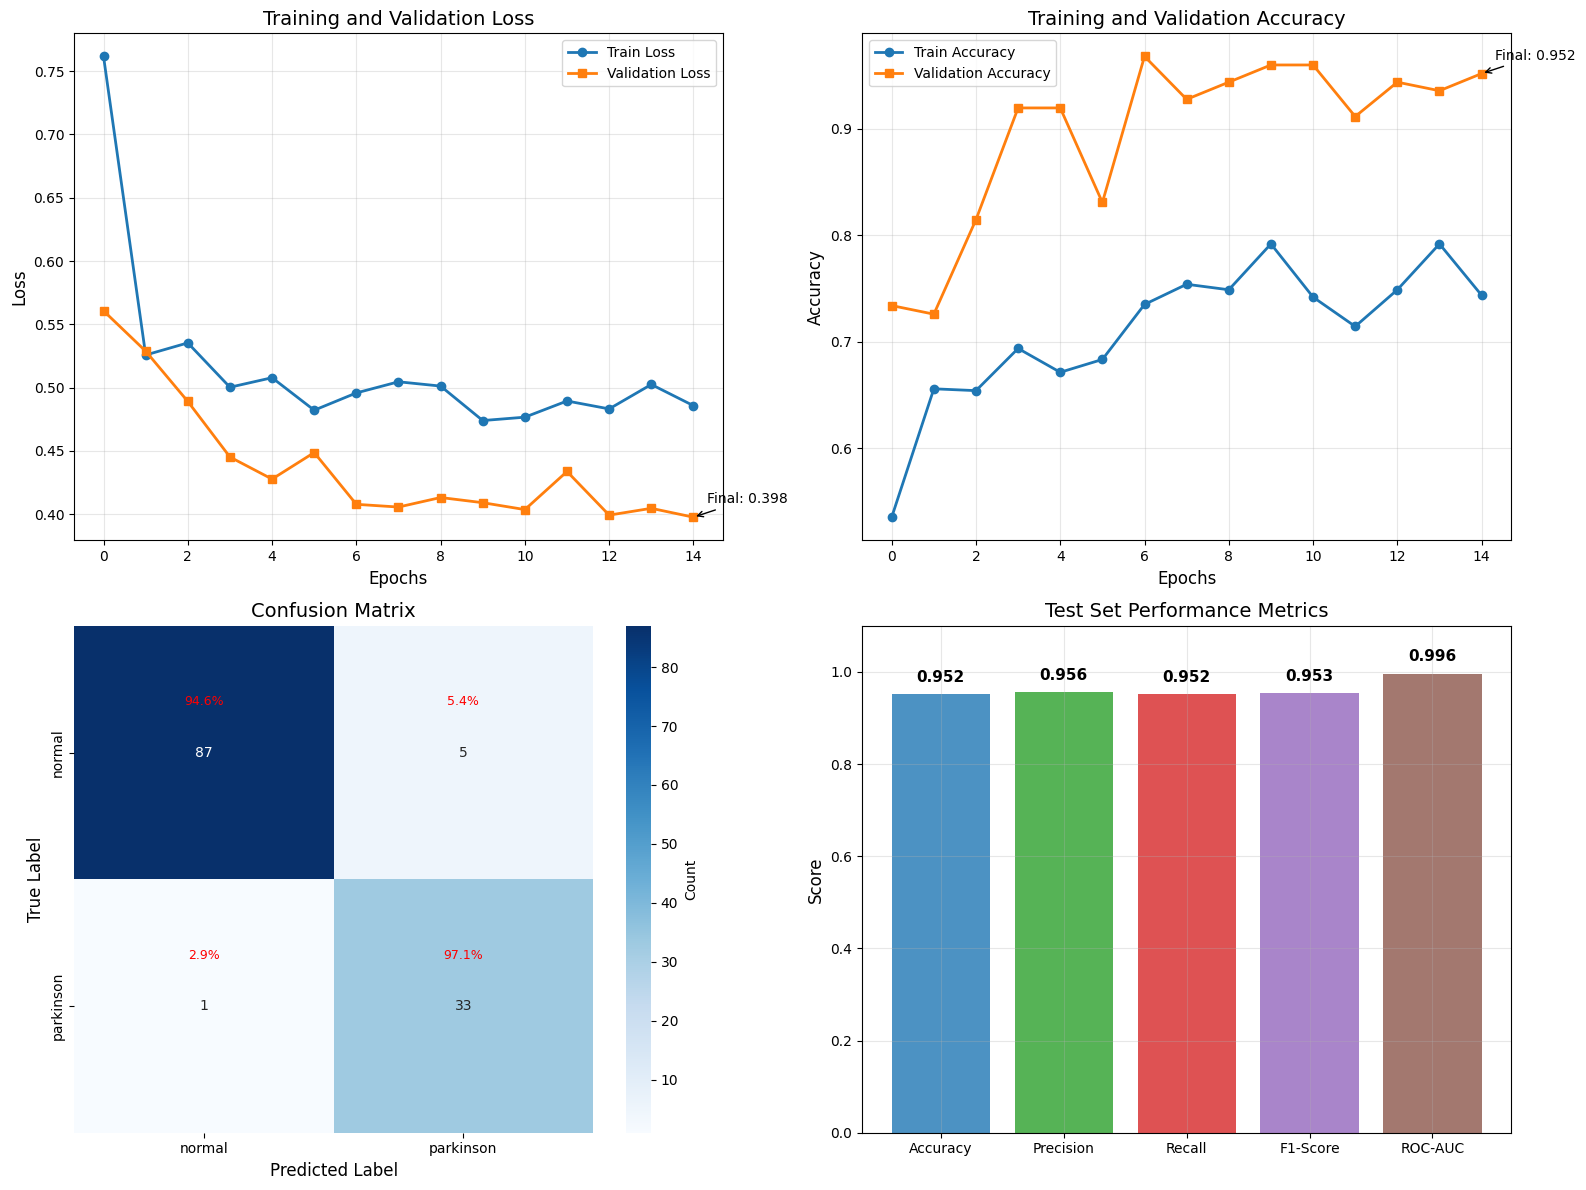

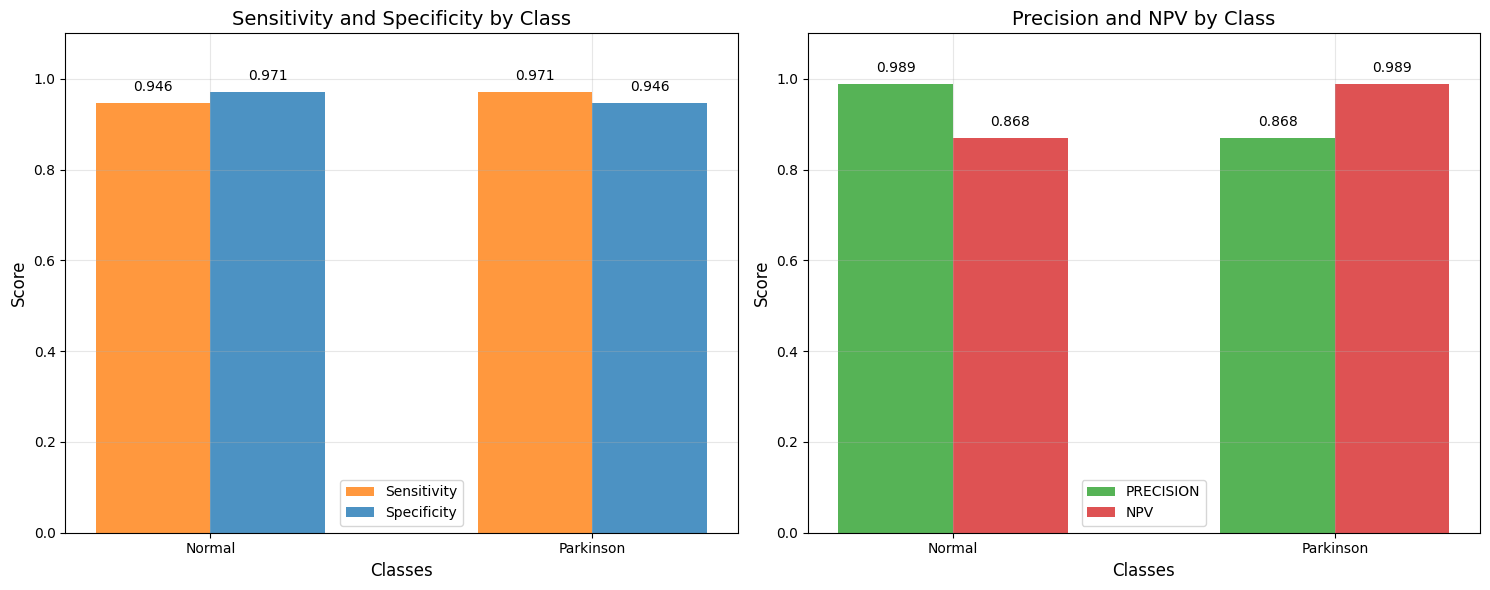

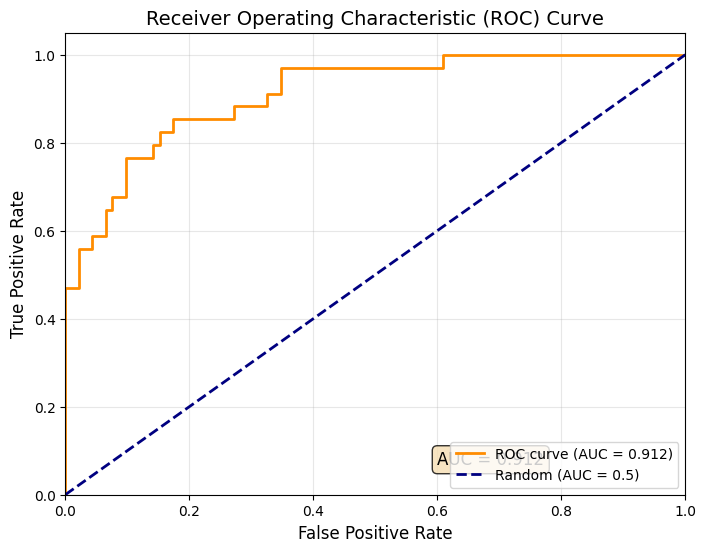

In [ ]:
# After multi-model comparison, analyze the best model
best_model_name = max(all_results.items(), key=lambda x: x[1]['test_metrics']['accuracy'])[0]
print(f"\nBest performing model: {best_model_name}")

# Display detailed results for the best model
if best_model_name in all_results:
    results = all_results[best_model_name]

    print(f"\n{'='*60}")
    print(f"DETAILED ANALYSIS FOR BEST MODEL: {best_model_name}")
    print(f"{'='*60}")

    print(f"Accuracy: {results['test_metrics']['accuracy']:.4f}")
    print(f"Precision: {results['test_metrics']['precision']:.4f}")
    print(f"Recall: {results['test_metrics']['recall']:.4f}")
    print(f"F1-Score: {results['test_metrics']['f1_score']:.4f}")
    print(f"ROC-AUC: {results['test_metrics']['roc_auc']:.4f}")

    print(f"\nClass-wise Performance:")
    for class_name, metrics in results['test_class_metrics'].items():
        print(f"{class_name}:")
        print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
        print(f"  Specificity: {metrics['specificity']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  NPV: {metrics['npv']:.4f}")

    # Generate visualizations for the best model
    train_losses, val_losses, train_accuracies, val_accuracies = results['train_history']
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies,
                results['test_metrics'], results['test_cm'], class_names, results['test_class_metrics'])
    plot_class_performance(results['test_class_metrics'], class_names)

    # Plot ROC curve
    test_labels, test_probs, _ = get_test_predictions(model, test_loader)  # Fixed this line
    plot_roc_curve(test_labels, test_probs, class_names)  # Use the actual test predictions
else:
    print(f"Model {best_model_name} not found in results")